# Highlight->Summarize experiments

In [1]:
import os
import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.hs import HSBaseline, HSStructuredHighlighter
from src.qa import QAEvaluator
from src.judges import LLMJudge, JUDGES
from src.utils import openai_client, NOANSWER_PRED

/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## repliqa dataset
Here we're only using the `repliqa_3` split.

In [2]:
dataset_name = f"repliqa_3"
repliqa = datasets.load_dataset("ServiceNow/repliqa")[dataset_name]
topics = list(set(repliqa["document_topic"]))
topics, len(repliqa)

(['Local Environmental Issues',
  'Local Economy and Market',
  'Cybersecurity News',
  'Regional Cuisine and Recipes',
  'Regional Folklore and Myths',
  'Local Sports and Activities',
  'Incident Report',
  'Neighborhood Stories',
  'Local Arts and Culture',
  'Company Policies',
  'Local Education Systems',
  'Local Health and Wellness',
  'News Stories',
  'Small and Medium Enterprises',
  'Local News',
  'Local Politics and Governance',
  'Local Technology and Innovation'],
 17955)

We clean up the dataset first. These examples that are discarded by these filters were manually inspected.

In [3]:
count = 0

def fix_label(example):
    global count
    if example["answer"] == "The answer is not found in the document.":
        return {"answer": NOANSWER_PRED}

    # Fix wrongly labelled.
    wrongly_labelled = [
        "The title of the mural is not mentioned in the document.",
        "Clara Bennett's book release date is not provided in the document.",
        "The document doesn't specify the exact date, it only mentions the 'late 2010s.'"
    ]
    if "The document does not" in example["answer"] or example["answer"] in wrongly_labelled:
        count += 1
        return {"answer": NOANSWER_PRED}
    
    return example

clean_repliqa = repliqa.map(fix_label)
print(f"Fixed {count} labels. (If this has been run more than once, the number will be 0 because the processed dataset is cached.)")

Loading: True
Fixed 0 labels. (If this has been run more than once, the number will be 0 because the processed dataset is cached.)


## Evaluation

### Run all models

What should we evaluate:

In [4]:
RESULTS_DIR = f"results/{dataset_name}"
TEMPERATURE = 0.2
PIPELINES = [
    {
        "pipeline": QAEvaluator,
        "model_name": "gpt-4.1-mini",
        "temperature": TEMPERATURE,
    },
    {
        "pipeline": HSBaseline,
        "model_name": "gpt-4.1-mini",
        "temperature": TEMPERATURE,
    },
    {
        "pipeline": HSStructuredHighlighter,
        "model_name": "gpt-4.1-mini",
        "temperature": TEMPERATURE,
    }
]
N_PROC = 1
N_TRIALS = 5
# Data.
from datasets import concatenate_datasets
N = 20
DATASET = clean_repliqa.select(range(N))
DATASET = concatenate_datasets([
    DATASET,
    clean_repliqa.filter(lambda example: example["answer"] == NOANSWER_PRED).select(range(N))
])
print(f"Dataset size: {N}")
print(f"Number of unanswerable questions: {len(DATASET)-N}")

Loading: True
Dataset size: 20
Number of unanswerable questions: 20


**Do it**

In [5]:
inference_datasets = {}
os.makedirs(RESULTS_DIR, exist_ok=True)

for pipeline in PIPELINES:
    model_name = pipeline["model_name"]
    rag_pipeline = pipeline["pipeline"]
    temperature = pipeline["temperature"]
    run_id = f"{rag_pipeline.__name__}-{model_name}"

    print(f"* Running inference for: {model_name} with {rag_pipeline.__name__} pipeline.")
    ######################
    # Question answering.
    ######################
    # Try loading from disk.
    try:
        prediction_dataset = datasets.load_from_disk(os.path.join(RESULTS_DIR, f"{run_id}.predicted"))
        if "answer_pred" in prediction_dataset.column_names:
            print(f"Skipping predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        else:
            raise Exception("This shouldn't happen: missing 'answer_pred' column but dataset exists.")
    except FileNotFoundError:
        print(f"Generating predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        pipeline = rag_pipeline(
            model_name=model_name,
            openai_client=openai_client,
            temperature=temperature,
            n_trials=N_TRIALS,
        )
        prediction_dataset = DATASET.map(
            pipeline,
            desc=f"Generating predictions (Model: {model_name}, Pipeline: {rag_pipeline.__name__})",
            num_proc=N_PROC,
            load_from_cache_file=False,
            #input_columns=["question_id", "question", "answer", "document_extracted", "entity_pages"]
            )
        # Store.
        print(f"Storing predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        prediction_dataset.save_to_disk(os.path.join(RESULTS_DIR, f"{run_id}.predicted"))

    #######################
    # Judges.
    #######################
    try:
        judged_dataset = datasets.load_from_disk(os.path.join(RESULTS_DIR, f"{run_id}.judged"))
        print(f"Skipping judging for: {model_name} with {rag_pipeline.__name__} pipeline.")
    except OSError:
        judged_dataset = prediction_dataset
        for judge_name in JUDGES:
            judge = LLMJudge(
                judge_name=judge_name,
                openai_client=openai_client,
            )
            judged_dataset = judged_dataset.map(
                judge,
                desc=f"Judging predictions for: {model_name} with {rag_pipeline.__name__} pipeline. (Judge: {judge_name})",
                num_proc=N_PROC,
                load_from_cache_file=False,
            )
        # Store.
        print(f"Storing judged predictions for: {model_name} with {rag_pipeline.__name__} pipeline.")
        judged_dataset.save_to_disk(os.path.join(RESULTS_DIR, f"{run_id}.judged"))
    
    # Join the datasets.
    inference_datasets[run_id] = judged_dataset
    print()

* Running inference for: gpt-4.1-mini with QAEvaluator pipeline.
Skipping predictions for: gpt-4.1-mini with QAEvaluator pipeline.
Skipping judging for: gpt-4.1-mini with QAEvaluator pipeline.

* Running inference for: gpt-4.1-mini with HSBaseline pipeline.
Skipping predictions for: gpt-4.1-mini with HSBaseline pipeline.
Skipping judging for: gpt-4.1-mini with HSBaseline pipeline.

* Running inference for: gpt-4.1-mini with HSStructuredHighlighter pipeline.
Generating predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline.
Loading: False


Generating predictions (Model: gpt-4.1-mini, Pipeline: HSStructuredHighlighter): 100%|██████████| 40/40 [05:55<00:00,  8.88s/ examples]


Storing predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline.


Saving the dataset (1/1 shards): 100%|██████████| 40/40 [00:00<00:00, 1676.87 examples/s]


Loading: False


Judging predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline. (Judge: MT-bench-QA): 100%|██████████| 40/40 [01:33<00:00,  2.34s/ examples]


Loading: False


Judging predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline. (Judge: Correctness): 100%|██████████| 40/40 [01:24<00:00,  2.12s/ examples]


Loading: False


Judging predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline. (Judge: Naturalness): 100%|██████████| 40/40 [01:22<00:00,  2.06s/ examples]


Storing judged predictions for: gpt-4.1-mini with HSStructuredHighlighter pipeline.


Saving the dataset (1/1 shards): 100%|██████████| 40/40 [00:00<00:00, 563.93 examples/s]

**Store to Excel for manual inspection**

In [6]:
import pandas as pd
select = ["question", "answer", "answer_pred", "model_name", "temperature"]
try_select = ['summarizer_llm_response', 'summarizer_llm_guessed_question', 'highlighter_extracted', 'highlighter_llm_response', 'highlighter_text_extracts', 'highlighter_fuzzmatch_scores']
select += [f"{judge_name}_rating" for judge_name in JUDGES]
select += [f"{judge_name}_explanation" for judge_name in JUDGES]
to_cat = []

for model_name, dataset in inference_datasets.items():
    try:
        to_cat.append(pd.DataFrame(dataset)[select + try_select])
    except KeyError:
        to_cat.append(pd.DataFrame(dataset)[select])
    to_cat[-1]["pipeline"] = model_name.split("-")[0]
    if "raw_text_extracts" in dataset.column_names:
        to_cat[-1]["raw_text_extracts"] = dataset["raw_text_extracts"]
    else:
        to_cat[-1]["raw_text_extracts"] = None

df = pd.concat(to_cat, ignore_index=True)
df.to_excel(
    os.path.join(RESULTS_DIR, "repliqa_results.xlsx"),
    index=False,
    engine="openpyxl"
)

#### Data analysis

**Scores on answerable questions**

In [7]:
MIN_RATING = 1
MAX_RATING = 5

ratings = {}

for model_name in inference_datasets:
    dataset = inference_datasets[model_name].filter(
        lambda example: example["answer"] != NOANSWER_PRED
    )
    # For all judges.
    for col in dataset.column_names:
        if col.endswith("_rating"):
            ratings.setdefault(model_name, {})[col] = dataset[col]

Loading: True
Loading: True
Loading: True


Filter: 100%|██████████| 40/40 [00:00<00:00, 2138.45 examples/s]


##### Correct questions (among those that can be answered)

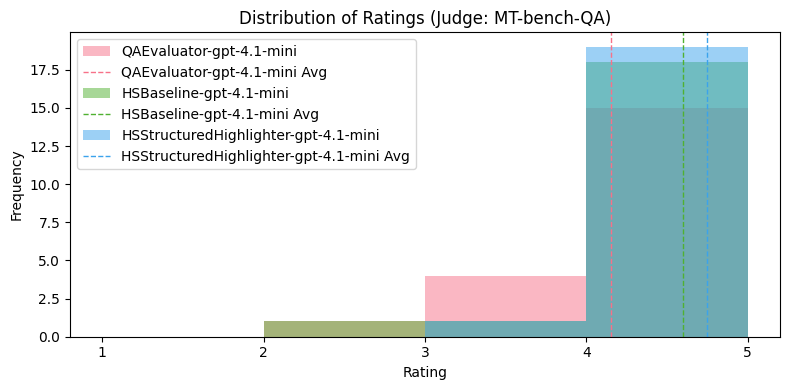

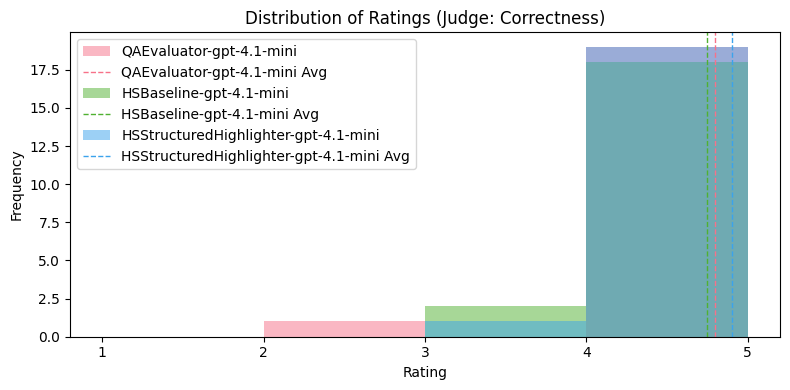

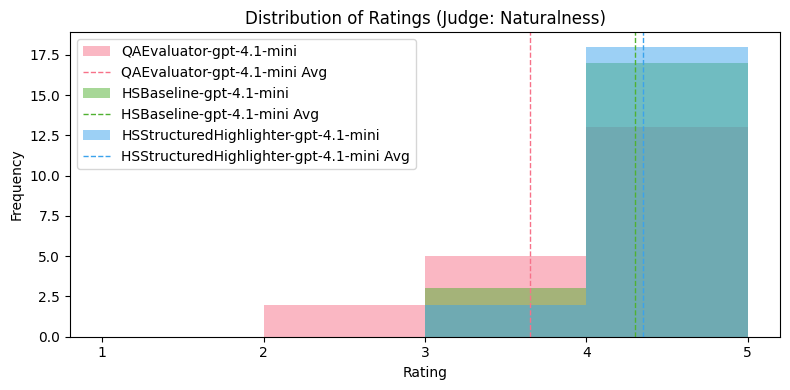

In [8]:
judge_names = JUDGES

for judge_name in judge_names:
    plt.figure(figsize=(8, 4))
    colors = sns.color_palette("husl", len(ratings))
    for model_name, model_ratings in ratings.items():
        color = colors.pop(0)
        judge_ratings = model_ratings[f"{judge_name}_rating"]
        plt.hist(judge_ratings, alpha=0.5, label=f"{model_name}", color=color, density=False, bins=np.arange(MIN_RATING, MAX_RATING + 1, 1))
        # A vertical line for each model's average rating.
        avg_rating = np.mean(judge_ratings)
        plt.axvline(avg_rating, linestyle='--', linewidth=1, label=f"{model_name} Avg", color=color)

    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Ratings (Judge: {judge_name})")
    plt.xticks(np.arange(MIN_RATING, MAX_RATING + 1, 1))
    plt.legend()
    plt.tight_layout()

#### Unanswerable

Loading: True
Loading: True
Loading: True
Loading: True
Loading: True
Loading: True
Loading: True
Loading: True
Loading: True
Loading: True


Filter: 100%|██████████| 40/40 [00:00<00:00, 1266.52 examples/s]


Loading: True


Filter: 100%|██████████| 20/20 [00:00<00:00, 571.02 examples/s]


Loading: True


Filter: 100%|██████████| 20/20 [00:00<00:00, 798.19 examples/s]


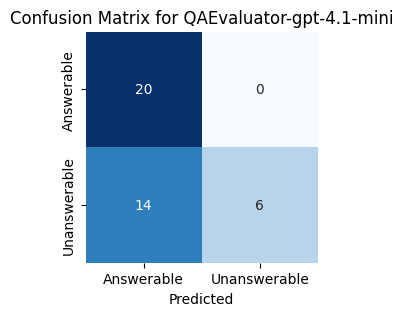

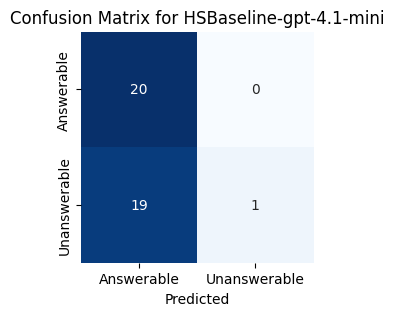

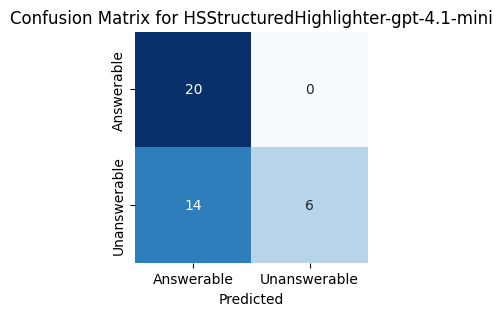

In [9]:
# Confusion matrix for (answer is answerable/unanswerable, answer_pred is answerable/unanswerable)
for model_name in inference_datasets:
    answerable = inference_datasets[model_name].filter(
        lambda example: example["answer"] != NOANSWER_PRED
    )
    unanswerable = inference_datasets[model_name].filter(
        lambda example: example["answer"] == NOANSWER_PRED
    )
    answerable_correct = len(answerable.filter(lambda example: example["answer_pred"] != NOANSWER_PRED))
    unanswerable_correct = len(unanswerable.filter(lambda example: example["answer_pred"] == NOANSWER_PRED))

    # Plot as confusion matrix.
    confusion_matrix = np.array([[answerable_correct, len(answerable) - answerable_correct],
                                  [len(unanswerable) - unanswerable_correct, unanswerable_correct]])
    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Answerable", "Unanswerable"],
                yticklabels=["Answerable", "Unanswerable"])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted") 

#### Recall and K-F1

Referring to https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00667/121196.

In [ ]:
import tiktoken

enc = tiktoken.encoding_for_model("gpt-4")
encode = lambda x: len(enc.encode(x))

def ref_answer_recall(answer, answer_pred):
    """This metric measures the proportion of tokens in the
    reference `answer` that are present in the model response.
    """
    if answer == NOANSWER_PRED:
        raise ValueError("Reference answer is NOANSWER_PRED.")

    if answer_pred == NOANSWER_PRED:
        return 0.0
    
    answer_tokens = set(enc.encode(answer))
    answer_pred_tokens = set(enc.encode(answer_pred))
    common_tokens = answer_tokens.intersection(answer_pred_tokens)
    recall = len(common_tokens) / len(answer_tokens)
    return recall

def ref_passage_precision(passage, answer_pred):
    """This metric measures the proportion of tokens in the model
    response `answer_pred` that are present in the "gold passage" `passage`.
    """
    if answer_pred == NOANSWER_PRED:
        return 0.0
    
    passage_tokens = set(enc.encode(passage))
    answer_pred_tokens = set(enc.encode(answer_pred))
    common_tokens = passage_tokens.intersection(answer_pred_tokens)
    precision = len(common_tokens) / len(answer_pred_tokens)
    return precision

In [23]:
results = {}
for model_name, dataset in inference_datasets.items():
    results[model_name] = {
        "ref_answer_recall": [],
        "ref_passage_precision": [],
        "answer_length": [],
        "answer_pred_length": []
    }
    for example in dataset:
        # We skip unanswerable questions.
        if example["answer"] == NOANSWER_PRED:
            continue
        results[model_name]["ref_answer_recall"].append(
            ref_answer_recall(example["answer"], example["answer_pred"])
        )
        results[model_name]["ref_passage_precision"].append(
            ref_passage_precision(example["long_answer"], example["answer_pred"])
        )
    print(f"Model: {model_name}")
    print(f"  Ref Answer Recall: {np.mean(results[model_name]['ref_answer_recall']):.4f}")
    print(f"  Ref Passage Precision: {np.mean(results[model_name]['ref_passage_precision']):.4f}")

    # We also evaluate just the highlighter for HS pipelines.
    if "HS" in model_name:
        results[f"{model_name}-highlighter"] = {
            "ref_answer_recall": [],
            "ref_passage_precision": [],
            "answer_length": [],
            "answer_pred_length": []
        }
        for example in dataset:
            if example["answer"] == NOANSWER_PRED:
                continue
            results[f"{model_name}-highlighter"]["ref_answer_recall"].append(
                ref_answer_recall(example["answer"], example["highlighter_extracted"])
            )
            results[f"{model_name}-highlighter"]["ref_passage_precision"].append(
                ref_passage_precision(example["long_answer"], example["highlighter_extracted"])
            )
        print(f"Model: {model_name}-highlighter")
        print(f"  Ref Answer Recall: {np.mean(results[f'{model_name}-highlighter']['ref_answer_recall']):.4f}")
        print(f"  Ref Passage Precision: {np.mean(results[f'{model_name}-highlighter']['ref_passage_precision']):.4f}")

Model: QAEvaluator-gpt-4.1-mini
  Ref Answer Recall: 0.6697
  Ref Passage Precision: 0.8101
Model: HSBaseline-gpt-4.1-mini
  Ref Answer Recall: 0.7633
  Ref Passage Precision: 0.7268
Model: HSBaseline-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.7327
  Ref Passage Precision: 0.8795
Model: HSStructuredHighlighter-gpt-4.1-mini
  Ref Answer Recall: 0.8202
  Ref Passage Precision: 0.7334
Model: HSStructuredHighlighter-gpt-4.1-mini-highlighter
  Ref Answer Recall: 0.7909
  Ref Passage Precision: 0.8879


# Unused

In [ ]:
# def evaluate_model(model_name: str, rag_pipeline: QAEvaluator | QAJudge, dataset: datasets.Dataset,
#                    temperature: float = 0.3, n_trials: int = 5) -> datasets.Dataset:
#     """
#     Evaluates a model on a dataset using the provided RAG pipeline.
#     """
#     print(f"Evaluating model: {model_name}")
#     pipeline = rag_pipeline(
#         model_name=model_name,
#         openai_client=openai_client,
#         temperature=temperature,
#         n_trials=n_trials,
#     )
#     prediction_dataset = dataset.map(
#         pipeline,
#         desc=f"Generating predictions",
#         num_proc=1,
#         # cache_file_name=os.path.join(
#         #     "predictions",
#         #     f"{model_name}_predictions_{rag_pipeline}.cache"
#         # ),
#         load_from_cache_file=True,
#         # remove_columns=['document_id', 'document_topic', 'document_path', 'document_extracted', 'question_id', 'long_answer']
#         )
#     prediction_dataset = prediction_dataset.map(judge, desc=f"Judging predictions", num_proc=1)
#     return prediction_dataset

In [66]:
inference_datasets = {}
N_RETRIALS = 5  # Maximum number of re-attempts after failed inference requests

for model in models:
    print(f"Processing model: {model}")
    qa_pre_processor = QAEvaluator(
      model_name=model,
      openai_client=openai_client,
      temperature=0.2,
      n_trials=N_RETRIALS,
    )
    prediction_dataset = repliqa.map(qa_pre_processor)
    prediction_dataset = prediction_dataset.map(
        judge, desc="Judging answers"
    )
    inference_datasets[model] = prediction_dataset

Processing model: gpt-4o


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map: 100%|██████████| 5/5 [00:03<00:00,  1.27 examples/s]
/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.QAJudgeResponse'>.
  StockPickler.save(self, obj, save_persistent_id)
/home/gcherubin/research/highlight-then-summarize/.venv/lib/python3.12/site-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.QAJudgeResponse'>: __main__.QAJudgeResponse has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Judging answers: 100%|██████████| 5/5 [00:13<00:00,  2.74s/ examples]


In [ ]:
import litellm
import instructor
client = instructor.from_litellm(litellm.completion)
client.chat.completions.create(
            model=JUDGE_LLM_NAME,
            max_tokens=1000,
            temperature=0.1,
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant that evaluates the correctness of answers to questions based on provided contexts.",
                },
                {
                    "role": "user",
                    "content": "Evaluate the correctness of the following answer based on the context provided. "
                               "If the answer is correct, output 'CORRECT'. If it is incorrect, output 'INCORRECT'. "
                               "Context: 'The capital of France is Paris.' Answer: 'Paris is the capital of France.'",
                },
            ],
            response_format={"type": "json_object"}
        )